In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
    '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
    '事故類型及型態子類別名稱', '死亡受傷人數',
    '肇因研判子類別名稱-個別'
    # '經度', '緯度'
]
print(len(select_lst))

def preprocess(input_data, select_lst):
    
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)
# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print(dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

23
(312760, 322)


In [46]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
# 回傳mca.row_coordinates(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.259         1.91%                      1.91%
1              0.182         1.34%                      3.26%
2              0.166         1.23%                      4.48%
3              0.146         1.08%                      5.56%
4              0.130         0.96%                      6.52%
5              0.118         0.87%                      7.40%
6              0.109         0.81%                      8.20%


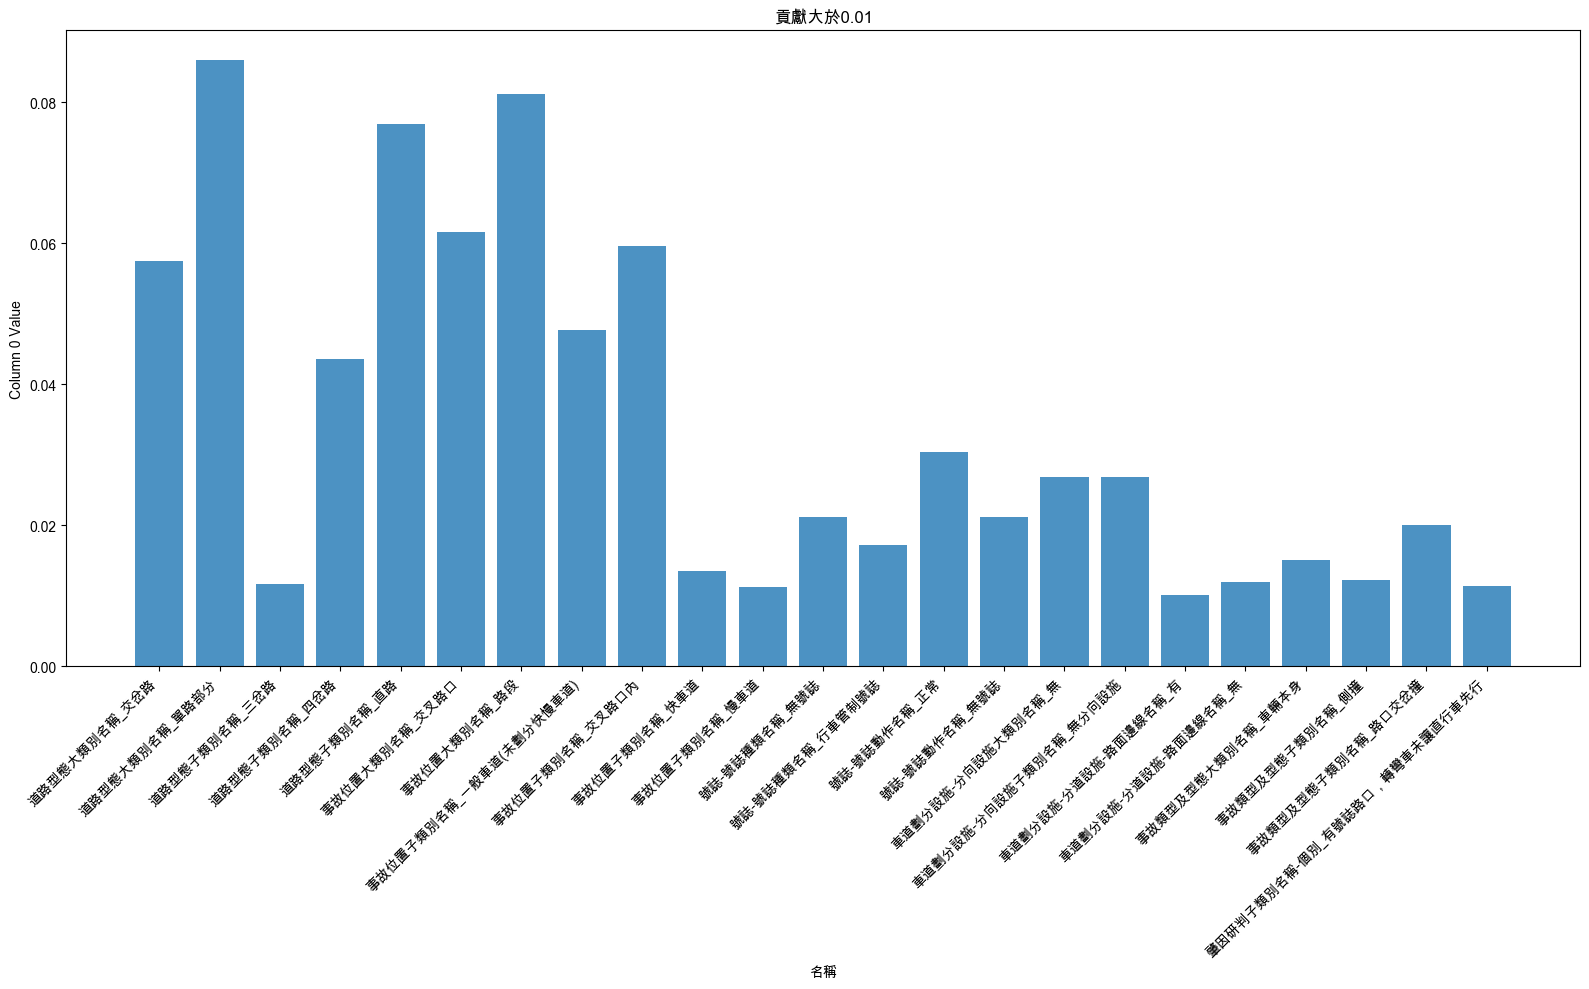

In [44]:
plt.rcParams['font.sans-serif']=['Arial Unicode Ms']

col_contribute = mca.column_contributions_
filtered_df = col_contribute[col_contribute[0] > 0.01]

# 視覺化
plt.figure(figsize=(16, 10))
plt.bar(filtered_df.index, filtered_df[0], alpha=0.8)
plt.xlabel('名稱')
plt.ylabel('Column 0 Value')
plt.title('貢獻大於0.01')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [72]:
col_contribute.sort_values(by=0)

,0,1,2,3,4,5,6
肇因研判子類別名稱-個別_違反禁止進入標誌,3.544847e-10,2.036738e-06,6.717164e-05,1.216904e-05,6.262307e-05,2.820685e-06,1.509284e-05
速限-第1當事者_58.0,7.616676e-10,4.628028e-09,4.558715e-08,3.936623e-07,1.382462e-08,3.343248e-07,1.601496e-09
速限-第1當事者_606.0,1.554691e-09,8.852395e-10,1.282367e-07,3.730878e-08,1.059680e-08,3.205324e-09,9.649965e-08
道路障礙-視距名稱_路上停放車輛,2.572617e-09,1.893653e-05,1.339024e-03,2.338233e-05,4.334326e-04,2.268483e-04,1.315475e-05
肇因研判子類別名稱-個別_違反車輛改道標誌,4.073615e-09,2.134161e-08,7.797895e-07,1.629420e-09,8.669994e-07,3.963357e-07,5.561711e-08
...,...,...,...,...,...,...,...
事故位置子類別名稱_交叉路口內,5.962336e-02,3.823315e-05,3.305605e-05,1.571588e-03,2.125480e-03,3.343837e-04,1.963878e-04
事故位置大類別名稱_交叉路口,6.156438e-02,1.572194e-04,3.760307e-03,1.626272e-04,3.040513e-04,1.038052e-06,8.624763e-04
道路型態子類別名稱_直路,7.693071e-02,1.382763e-07,5.878937e-04,1.810303e-03,2.329316e-03,6.335832e-04,4.394229e-03
事故位置大類別名稱_路段,8.116492e-02,6.418281e-07,1.366721e-03,4.223998e-03,1.927339e-03,1.886090e-06,5.975305e-04


In [41]:
col_coordinate = mca.column_coordinates(data_to_map)
col_coordinate[col_coordinate[1] > 10]

,0,1,2,3,4,5,6,7,8,9
速限-第1當事者_15.0,0.166849,10.452720,0.601584,0.251471,0.326086,-0.628932,0.248569,-0.034255,0.376135,-0.382951
道路型態大類別名稱_平交道,-0.428842,140.783815,19.646950,9.670874,-1.988613,1.873988,0.435015,-0.061141,-0.017788,-0.001682
道路型態子類別名稱_有遮斷器,-0.428842,140.783815,19.646950,9.670874,-1.988613,1.873988,0.435015,-0.061141,-0.017788,-0.001682
事故類型及型態大類別名稱_平交道事故,-1.207262,296.627060,46.166761,26.353480,-7.406868,8.880609,-0.445808,0.771752,-0.558565,3.016825
事故類型及型態子類別名稱_正越過平交道中,-1.233904,296.281317,46.907905,27.177418,-7.910274,9.640019,-0.533041,0.506582,-0.210936,3.905894
事故類型及型態子類別名稱_衝過(或撞壞)遮斷器,-1.193941,296.799932,45.796189,25.941510,-7.155166,8.500905,-0.402191,0.904338,-0.732380,2.572291
肇因研判子類別名稱-個別_搶(闖)越平交道,-1.207262,296.627060,46.166761,26.353480,-7.406868,8.880609,-0.445808,0.771752,-0.558565,3.016825


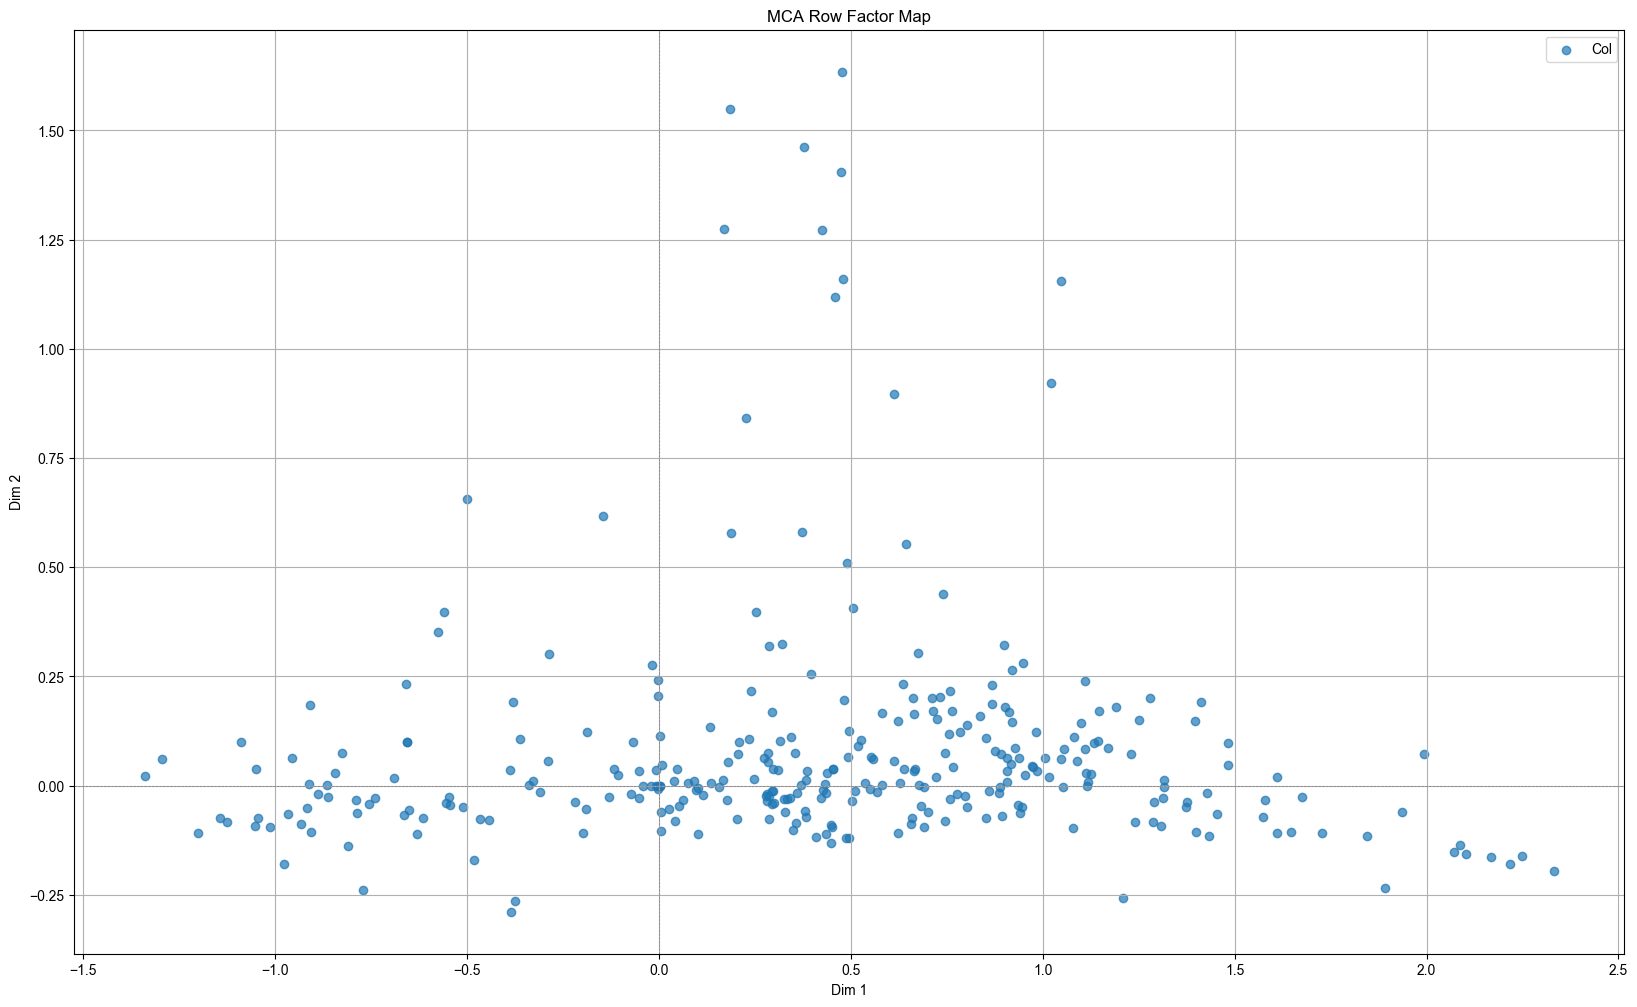

In [70]:
col_coordinate = mca.column_coordinates(data_to_map)
col_coordinate = col_coordinate[col_coordinate[1] < 10]
plt.figure(figsize=(20, 12))
plt.scatter(col_coordinate[0], col_coordinate[1], alpha=0.7, label="Col")

# for i, label in enumerate(col_coordinate.index):
#     plt.text(
#         col_coordinate[0][i], 
#         col_coordinate[1][i], 
#         str(label), 
#         fontsize=10, 
#         ha='right', 
#         va='bottom',
#         rotation=45
#     )

plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title("MCA Row Factor Map")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.legend()
plt.show()